In [1]:
import quantecon as qe
import numpy as np
from numba import njit
import pandas as pd

## Simulation

In [2]:
# Define Parameters:

κ = np.float64(0.7)            # Debt Recovery Factor.
n_a = np.int64(2000)           # Asset Grid.
n_z = np.int64(5)              # Markov States.
σ = np.float64(2)              # Risk Aversion.
ρ = np.float64(0.875)          # Memory of Income
σ_y = np.float64(0.052)        # Shock Process.
β = np.float64(0.954)          # Discont Factor.
γ_0 = np.float64(0.0476)       # Default Costs.
γ_1 = np.float64(2 )           # Default Costs.
μ = np.float64(0.1)            # Weight on new prices.
error_q = np.float64(10e-6)    # Error tolerance.
error_v = np.float64(10e-6)    # Error tolerance value function.
max_iter = np.int64(5000)      # Max Iterations.
R = np.float64(1.04)           # Real interest Rate.
θ = np.float64(1.3)            # Expanding grid 

markov = qe.markov.approximation.rouwenhorst(n = n_z, ybar = 0, sigma = σ_y, rho= ρ)

# Probability matrix and states:
# Element (i,j) of \Pi represents the transition probability of going to state "j" given that we are in state "i".
# The process generated by this approximation is and AR(1). we are assuming that ln(z) is an AR(1) with mean 0 and sd sigma.
# To get the values for the technology we just need to take exponentials.

Π = markov.P   
Z = np.exp(markov.state_values)
Z_i = np.linspace(0, n_z - 1, n_z).astype(np.int32)   # Grid of indexes for Z.
A = (0.5*Z[-1]) * (np.linspace(0, 1, n_a)**θ)         # Asset Grid.
A_i = np.linspace(0, n_a - 1, n_a).astype(np.int32)   # Grid of indexes for A.


In [3]:
@njit
def u(c):
    return np.log(c)

In [4]:
q_0 = np.ones((n_a, n_z), dtype = np.float64) * 1/R
q_1 = np.empty_like(q_0, dtype = np.float64)
V_0 = np.ones((n_a, 1)) * u(Z) / (1 - β)
V_1 = np.empty_like(V_0, dtype = np.float64)
a_star = np.empty_like(q_0, dtype=np.int64)
q_star = np.empty_like(q_0, dtype = np.float64)
iter = np.int64(0)

In [5]:
@njit
def d(i_a, i_z, q):
    num = (1 - R * κ * q[:, i_z]) *  A[i_a]
    den = Z[i_z] * γ_0 * γ_1
    aux = (num/den)**(1/(γ_1 - 1))
    return np.where(aux<0, 0, np.where(aux > 1, 1, aux))

In [6]:
def v_update(i_a, i_z, d_star, q_0, a_star):
        aux = u(Z[i_z] * (1 - γ_0 * d_star[i_a, i_z]**(γ_1) ) - A[i_a] * (1 - d_star[i_a, i_z]) + q_0[a_star[i_a, i_z], i_z] * (A[a_star[i_a, i_z]] - R * κ * d_star[i_a, i_z] * A[i_a])) + β * np.matmul(V_0[a_star[i_a, i_z], :], Π[i_z, :])
        return aux

In [7]:
def q_update(i_a_p, i_z, d_star, a_star, q_0):
        return (1/R) * np.matmul(Π[i_z, :].T, (1 - d_star[i_a_p, :]) + R * κ * d_star[i_a_p, :] * np.diag(q_0[a_star[i_a_p, :], :]))

In [8]:
while iter < max_iter:

    for i_z in Z_i:
        for i_a in A_i:
            obj = u(Z[i_z] * ( 1 - γ_0 * d(i_a, i_z, q_0)**(γ_1)) - A[i_a] * (1 - d(i_a, i_z, q_0)) + q_0[:, i_z] * (A - R * κ * d(i_a, i_z, q_0)* A[i_a])) + β * np.matmul(V_0, Π[i_z, :])
            a_star[i_a, i_z] = np.nanargmax(obj)
        q_star[:, i_z] = q_0[a_star[:, i_z], i_z]    

    d_star = (((1 - R * κ * q_star).T * A).T / (Z * γ_0 * γ_1) )**(1/(γ_1 - 1))
    d_star = np.where(d_star<0, 0, np.where(d_star > 1, 1, d_star))

    for i_z in Z_i:
        for i_a in A_i:
            V_1[i_a, i_z] = v_update(i_a, i_z, d_star, q_0, a_star)
            q_1[i_a, i_z] = q_update(i_a, i_z, d_star, a_star, q_0)

    iter +=1

    if np.max(np.abs(q_1 - q_0)) > error_q and np.max(np.abs(V_0 - V_1)) > error_v:
        if iter % 10 == 0:
            print(f"q, V", np.max(np.abs(q_1 - q_0)), np.max(np.abs(V_0 - V_1)))     
        q_0 = μ * q_1.copy() + (1-μ) * q_0.copy()
        V_0 = V_1.copy()
        continue
    else:
        print("convergence!")
        break

if iter == max_iter:
    print("fail")

q, V 0.24986747538980625 0.15418704214106893
q, V 0.21698745279446358 0.01870239087708958
q, V 0.17960983653507695 0.022542602219725788
q, V 0.14328324243074994 0.03095281094892055
q, V 0.42945053590411875 0.031095034262021537
q, V 0.5295387291160287 0.02769251878211909
q, V 0.2548915999808152 0.012960981525591775
q, V 0.1314683757049493 0.006916869859973751
q, V 0.06028853309911697 0.0037663915219674493
q, V 0.02584623116508733 0.002223392609571162
q, V 0.011555343279378683 0.0013669694889817396
q, V 0.009501685863521181 0.0008486537428677998
q, V 0.011294773174455486 0.0005275663499106908
q, V 0.009744127819763082 0.0003300687676222047
q, V 0.010506732841174288 0.00020945416155115915
q, V 0.009395379245003888 0.00013811928982887522
q, V 0.015292902181805068 8.468152979013155e-05
q, V 0.01340740951264141 5.9221815516430354e-05
q, V 0.015046803678066656 3.530133779616751e-05
q, V 0.012454895263047217 2.3104477111957067e-05
q, V 0.013293285728444348 1.8035223749990337e-05
q, V 0.0161300

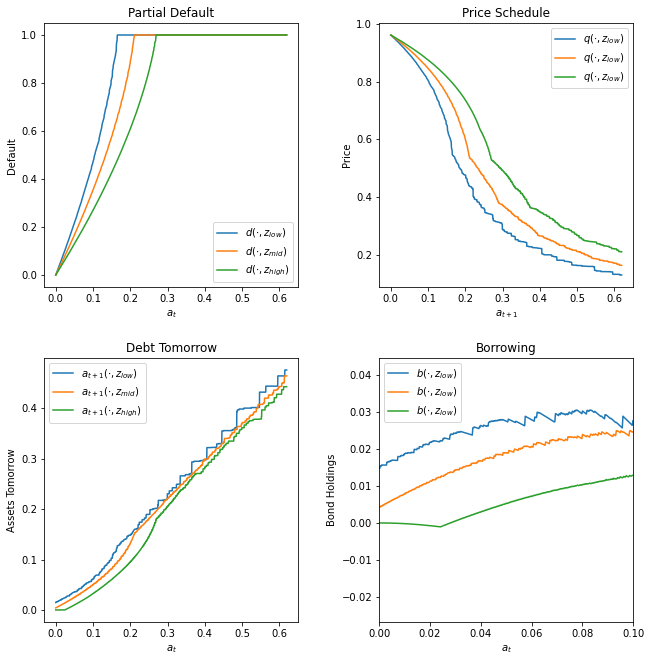

In [16]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(2,2, figsize=(10,10))
fig.tight_layout(pad=5.0)
ax[0,0].plot(A, d_star[:, 0], label=r'$d(\cdot, z_{low})$')
ax[0,0].plot(A, d_star[:, 2], label=r'$d(\cdot, z_{mid})$')
ax[0,0].plot(A, d_star[:, 4], label=r'$d(\cdot, z_{high})$')
ax[0,0].set(xlabel=r'$a_t$', ylabel = "Default")
ax[0,0].legend()
ax[0,0].title.set_text('Partial Default')
ax[1,0].plot(A, A[a_star[:, 0]], label=r'$a_{t+1}(\cdot, z_{low})$')
ax[1,0].plot(A, A[a_star[:, 2]], label=r'$a_{t+1}(\cdot, z_{mid})$')
ax[1,0].plot(A, A[a_star[:, 4]], label=r'$a_{t+1}(\cdot, z_{high})$')
ax[1,0].set(xlabel=r'$a_t$', ylabel = "Assets Tomorrow")
ax[1,0].legend()
ax[1,0].title.set_text('Debt Tomorrow')
ax[0,1].plot(A, q_1[:, 0], label=r'$q(\cdot, z_{low})$')
ax[0,1].plot(A, q_1[:, 2], label=r'$q(\cdot, z_{low})$')
ax[0,1].plot(A, q_1[:, 4], label=r'$q(\cdot, z_{low})$')
ax[0,1].set(xlabel=r'$a_{t+1}$', ylabel = 'Price')
ax[0,1].legend()
ax[0,1].title.set_text('Price Schedule')
ax[1,1].plot(A, A[a_star[:, 0]] - R * κ * A * d_star[:, 0], label=r'$b(\cdot, z_{low})$')
ax[1,1].plot(A, A[a_star[:, 2]] - R * κ * A * d_star[:, 2], label=r'$b(\cdot, z_{low})$')
ax[1,1].plot(A, A[a_star[:, 4]] - R * κ * A * d_star[:, 4], label=r'$b(\cdot, z_{low})$')
ax[1,1].set_xlim([0, 0.1])
ax[1,1].set(xlabel=r'$a_t$', ylabel = "Bond Holdings")
ax[1,1].legend()
ax[1,1].title.set_text('Borrowing')
plt.savefig('Exercise2.png')
plt.show()


In [17]:
T = 10000
Y = markov.simulate_indices(ts_length= T)
y_sim_without_cost = Z[Y]

### Create Vector for simulations:
# Income vector
y_sim = np.empty(T, dtype=np.float64)
# Asset vector:
a_sim_i = np.empty(T+1, dtype = np.int64)
# Assume that the there is no initial stock of assets:
a_sim_i[0] = 0
# Default decisions vector:
d_sim = np.empty(T, dtype = np.float64)
# Price vector:
q_sim = np.empty(T, dtype = np.float64)
# Spreads:
sprd_sim = np.empty(T, dtype = np.float64)
# Bonds:
b_sim = np.empty(T, dtype=np.float64)

# Simulate the economy and fill vectors:
for t in range(T):
    a_sim_i[t+1] = a_star[a_sim_i[t], Y[t]]
    d_sim[t] = d_star[a_sim_i[t], Y[t]]
    q_sim[t] = q_1[a_sim_i[t+1], Y[t]]
    b_sim[t] = A[a_sim_i[t+1]] - R * κ * d_star[a_sim_i[t], Y[t]] * A[a_sim_i[t]]
    y_sim[t] = (1-γ_0 * d_sim[t]**(γ_1))* y_sim_without_cost[t]
sprd_sim = 1/R - q_sim

In [18]:
#Table 2 statistics:

print(f'% Time in Partial default:', (np.size(d_sim[d_sim>0.001])/T) * 100)
print(f'Mean of Partial default:', np.mean(d_sim))
print(f'St. dev', np.std(d_sim))
print(f'Mean of Debt to output:', np.mean(A[a_sim_i[0:-1]]/y_sim))
print(f'Std of Debt to output:', np.std(A[a_sim_i[0:-1]]/y_sim))
print(f'Mean, Debt service/ Output:', np.mean((A[a_sim_i[0:-1]]*(1-d_sim))/y_sim))
print(f'Std, Debt service/ Output:', np.std((A[a_sim_i[0:-1]]*(1-d_sim))/y_sim))
print(f'Mean, Spreads:', np.mean(sprd_sim))
print(f'Std, Spreads:', np.std(sprd_sim))
print(f'Mean output', np.mean(y_sim))
print(f'Std output', np.std(y_sim))

% Time in Partial default: 67.35
Mean of Partial default: 0.02853191568627837
St. dev 0.028484992465614024
Mean of Debt to output: 0.008705257648166261
Std of Debt to output: 0.008551315983478403
Mean, Debt service/ Output: 0.0082133575401635
Std, Debt service/ Output: 0.007872978919015403
Mean, Spreads: 0.008559636358650194
Std, Spreads: 0.008634722151948234
Mean output 1.0087123025406566
Std output 0.11218070260820805


In [19]:
# histogram partial default:
np.histogram(d_sim, bins = 4)

(array([6122, 1149, 2044,  685]),
 array([0.        , 0.02473983, 0.04947967, 0.0742195 , 0.09895933]))

In [20]:
# histogram debt to output:
np.histogram( A[a_sim_i[0:-1]]/y_sim , bins = 4)

(array([5785, 1429, 2101,  685]),
 array([0.        , 0.00732853, 0.01465706, 0.02198559, 0.02931413]))

In [21]:
# Histogram of spreads
np.histogram( sprd_sim , bins = 4)

(array([6201, 1031, 2084,  684]),
 array([0.        , 0.00739381, 0.01478761, 0.02218142, 0.02957523]))

## Empirics and accounting of Default Episodes

In [22]:
df = pd.read_csv('Monetary_Dataset_Clean.csv')

df["def episode"] = (df['Defaulted Coupons'] > 0) * 1
df["Debt Due"] = (df["Debt service"] + df["Defaulted Coupons"])
df['part_def'] = df["Defaulted Coupons"]/ df["Debt Due"]
df["Debt to GDP"] = df["Debt"]/ df["NomOutput"]

In [23]:
print("The mean of partial defaults conditional on default: ", df[df["part_def"] > 0]["part_def"].mean())

The mean of partial defaults conditional on default:  0.20383028076088514


In [24]:
print("The frequency of partial defaults: ", df["def episode"].sum()/421)

The frequency of partial defaults:  0.5534441805225653


In [25]:
import itertools

#Mean Default Episodes
Mean_def_years = []
Lower_2_mean = []
for i in df["Country Code"].unique():
    Data = df[df["Country Code"] == i]
    Episode = Data["def episode"]
    Episode_series = [(len(list(y))) for x, y in itertools.groupby(Episode) if x == 1]
    Def_mean = np.array(Episode_series).mean() #Mean Default episodes for each country
    Lower_2_mean.append(np.sum(np.array(Episode_series) <= 2) / len(np.array(Episode_series)))
    Mean_def_years.append(Def_mean) #Making a list

Mean_def = np.array(Mean_def_years).mean() #Mean of mean default episodes
Lower_2_def = np.array(Lower_2_mean).mean()
Mean_def , 100 * Lower_2_def 

(13.675925925925926, 34.25925925925925)

In [26]:
Mean_def_years

[13.0, 23.0, 24.0, 21.5, 7.333333333333333, 2.25, 9.0, 21.0, 2.0]

In [27]:
Before_Indices = {}
Beginning_Indices = {}
Middle_Indices = {}
After_Indices = {}
Pseudo_After_Indices = {}

beginning_list = []



for i in df["Country Code"].unique():
    Data = df[df["Country Code"] == i]
    Episode = Data["def episode"]

    beginning_list = []
    if Episode.iloc[0] == 1:
        beginning_list.append(Episode.index[0])

    beginning = np.array(beginning_list + list( Episode.diff()[Episode.diff() == 1].index.values)) #Beginning the default episode indices

    if Episode.iloc[0] == 1:
        before = (beginning - 1)[1:]
    else:    
        before = beginning - 1                                      #Before the default episode indices
    
    after = Episode.diff()[Episode.diff() == -1].index.values    #After the default episode indices
    
    pseudo_after = list(after)                                   #After the default episode indices for countries which still defaults at the end
    if Episode[Episode.index[-1]] == 1:
        pseudo_after.append(Episode.index[-1] + 1)

    mid = (beginning + pseudo_after) // 2                        #Middle of the default episode indices

    Before_Indices[i] = list(before)
    Beginning_Indices[i] = list(beginning)
    Middle_Indices[i] = list(mid)
    After_Indices[i] = list(after)
    Pseudo_After_Indices[i]= list(pseudo_after)
    print(i, "DONE!")
    

ARG DONE!
BRA DONE!
COL DONE!
ECU DONE!
IDN DONE!
MEX DONE!
PHL DONE!
RUS DONE!
ZAF DONE!


In [28]:
Before_Indices

{'ARG': [10, 12, 29],
 'BRA': [98],
 'COL': [113],
 'ECU': [157, 165],
 'IDN': [222, 234],
 'MEX': [265, 267, 270, 277],
 'PHL': [317, 339, 346],
 'RUS': [],
 'ZAF': [403]}

In [29]:
Beginning_Indices

{'ARG': [11, 13, 30],
 'BRA': [52, 99],
 'COL': [114],
 'ECU': [158, 166],
 'IDN': [208, 223, 235],
 'MEX': [266, 268, 271, 278],
 'PHL': [318, 340, 347],
 'RUS': [364],
 'ZAF': [404]}

In [30]:
Middle_Indices

{'ARG': [11, 21, 41],
 'BRA': [74, 99],
 'COL': [126],
 'ECU': [158, 187],
 'IDN': [210, 227, 239],
 'MEX': [266, 269, 273, 279],
 'PHL': [326, 343, 349],
 'RUS': [374],
 'ZAF': [405]}

In [31]:
After_Indices

{'ARG': [12, 29],
 'BRA': [97, 100],
 'COL': [138],
 'ECU': [159],
 'IDN': [212, 232, 244],
 'MEX': [267, 270, 275, 280],
 'PHL': [335, 346, 351],
 'RUS': [385],
 'ZAF': [406]}

### Calculating the Haircuts

In order to calculate the haircuts of the real data we still need to have $R$ and $κ$, and we are going to use the estimated parameters:

In [34]:
R = 1.04
κ = 0.7

In [35]:
# Calculating Haircuts

Debt_Due = {}
Default = {}
# Calculating Debt Due and Default rates for each default episode for each country
for k in Beginning_Indices.keys():
    begin_periods = Beginning_Indices[k]
    end_periods = Pseudo_After_Indices[k]
    debt_due = []
    default = []
    for i in range(len(begin_periods)):
        begin_periods[i]
        end_periods[i] 
        if end_periods[i] - 1 == begin_periods[i]:   #One period defaults
            debt_due.append(df["Debt Due"].iloc[begin_periods[i]])
            default.append(df["part_def"].iloc[begin_periods[i]])
        else:
            debt_due.append(np.array(list(df["Debt Due"].iloc[list(np.arange(begin_periods[i],end_periods[i]))])))
            default.append(np.array(list(df["part_def"].iloc[list(np.arange(begin_periods[i],end_periods[i]))])))

    Debt_Due[k] = debt_due
    Default[k] = default




In [36]:
Debt_Due["ARG"]

[2174533889.5,
 array([4.41695758e+09, 7.07070802e+09, 5.19466082e+09, 8.70749136e+09,
        7.09453894e+09, 7.89826656e+09, 1.07983379e+10, 1.67612910e+10,
        1.73836220e+10, 1.80883645e+10, 4.44783235e+09, 3.61454969e+09,
        5.25321493e+09, 6.99524047e+09, 9.33538322e+09, 9.60848311e+09]),
 array([1.40915246e+10, 9.99849638e+09, 1.71344716e+10, 3.57674146e+10,
        4.58767159e+10, 2.37222469e+10, 2.35729530e+10, 3.06293379e+10,
        3.32585952e+10, 3.69569285e+10, 2.21126063e+10, 2.62361345e+10,
        2.44246120e+10, 2.61637412e+10, 2.19294564e+10, 2.36721374e+10,
        2.90646496e+10, 3.50471671e+10, 3.19570721e+10, 3.38361362e+10,
        1.81767319e+10, 1.33148960e+10])]

In [37]:
# Defaulted Debt

Defaulted_Debt = {}
Restructured_Debt = {}
for k in Default.keys():
    sum_def_list = []
    sum_restructured_list = []
    def_country = Default[k]
    debt_country = Debt_Due[k]
    for i in range(len(def_country)):
        sum_debt = 0
        sum_restructured = 0
        if isinstance(def_country[i], np.floating): #To check one period defaults
            sum_debt = sum_debt + def_country[i]*debt_country[i]
            sum_restructured = sum_restructured + R * κ * def_country[i] * debt_country[i] * (1 - def_country[i])
        else:
            for j in range(len(def_country[i])):
                sum_debt = sum_debt + 1/(R ** j) *  def_country[i][j] * debt_country[i][j] 
                sum_restructured = sum_restructured + 1/(R ** j) * def_country[i][j] * debt_country[i][j] * R * κ * (1 - def_country[i][j])
        sum_def_list.append(sum_debt)
        sum_restructured_list.append(sum_restructured)

    Defaulted_Debt[k] = sum_def_list
    Restructured_Debt[k] = sum_restructured_list

In [38]:
Defaulted_Debt

{'ARG': [835000.0, 51877159013.51268, 245514694739.57352],
 'BRA': [39370826784.72545, 4492000.0],
 'COL': [1519322826.3893762],
 'ECU': [472999.99999999994, 17403317210.34999],
 'IDN': [143936126.0010241, 336854610.7517731, 57397893166.73606],
 'MEX': [5000.0, 2375421.369230769, 635822294.6886662, 5139458.653846154],
 'PHL': [1996412962.2922585, 7055624.176987581, 3806812.2186902594],
 'RUS': [154425810755.1777],
 'ZAF': [118411.20384615383]}

In [39]:
Restructured_Debt

{'ARG': [607646.5799542371, 12048706989.860704, 42770392375.05005],
 'BRA': [14757244182.333035, 3269685.004613368],
 'COL': [1002308801.9905552],
 'ECU': [340399.6134805229, 3313559041.025546],
 'IDN': [69215180.22590494, 242087676.66146374, 17765791560.973946],
 'MEX': [3639.9918867026213,
  1729027.1726544402,
  440625720.56096846,
  3740024.3469116935],
 'PHL': [1097798799.825768, 5135059.1233923035, 2770797.56272198],
 'RUS': [30117286369.512047],
 'ZAF': [86201.58182506997]}

In [40]:
Haircuts = {}
Haircuts_avg = {}

for k in Defaulted_Debt.keys():
    def_country = np.array(Defaulted_Debt[k])
    res_country = np.array(Restructured_Debt[k])

    Haircuts[k] = 1 - (res_country/def_country)
    Haircuts_avg[k] = np.mean(1 - (res_country/def_country))



In [41]:
print("Haircuts of for each country's default episode is: ")
Haircuts

Haircuts of for each country's default episode is: 


{'ARG': array([0.27227954, 0.76774544, 0.82579294]),
 'BRA': array([0.62517312, 0.2721093 ]),
 'COL': array([0.34029241]),
 'ECU': array([0.28033908, 0.80960187]),
 'IDN': array([0.51912573, 0.28132889, 0.69048008]),
 'MEX': array([0.27200162, 0.2721177 , 0.30699863, 0.27229216]),
 'PHL': array([0.45011437, 0.27220342, 0.27214756]),
 'RUS': array([0.80497246]),
 'ZAF': array([0.27201499])}

In [42]:
print("Haircuts average for each country is: ")
Haircuts_avg

Haircuts average for each country is: 


{'ARG': 0.6219393077830717,
 'BRA': 0.44864121200439055,
 'COL': 0.3402924088407787,
 'ECU': 0.544970477109245,
 'IDN': 0.4969782305359051,
 'MEX': 0.28085252857376086,
 'PHL': 0.3314884509412363,
 'RUS': 0.8049724575041466,
 'ZAF': 0.2720149865458029}

In [43]:
print("The average Haircuts of the data is: ", 100 * np.mean(np.array(list(Haircuts_avg.values()))))

The average Haircuts of the data is:  46.02388955375931


### Calculating The Lower Part of Table 6

In [48]:
Before_Partdef = {}
Before_Output = {}
Before_Debt = {}


for k,v in Before_Indices.items():
    Before_Partdef[k] = df.iloc[v]["part_def"].mean()
    Before_Output[k] = df.iloc[v]["Output"].mean()
    Before_Debt[k] = df.iloc[v]["Debt to GDP"].mean()

Before_Partdef, Before_Output, Before_Debt


before_part_def = np.nanmean(np.array(list(Before_Partdef.values())))
before_output = np.nanmean(np.array(list(Before_Output.values())))
before_debt = np.nanmean(np.array(list(Before_Debt.values())))

before_part_def, before_output, before_debt

(0.0, 0.03316412986482964, 0.18338242516123832)

In [49]:
Beginning_Partdef = {}
Beginning_Output = {}
Beginning_Debt = {}


for k,v in Beginning_Indices.items():
    Beginning_Partdef[k] = df.iloc[v]["part_def"].mean()
    Beginning_Output[k] = df.iloc[v]["Output"].mean()
    Beginning_Debt[k] = df.iloc[v]["Debt to GDP"].mean()

beginning_part_def = np.nanmean(np.array(list(Beginning_Partdef.values())))
beginning_output = np.nanmean(np.array(list(Beginning_Output.values())))
beginning_debt = np.nanmean(np.array(list(Beginning_Debt.values())))

beginning_part_def, beginning_output, beginning_debt

(0.1333830793376952, 0.03900835201306163, 0.1806026053411025)

In [50]:
Middle_Partdef = {}
Middle_Output = {}
Middle_Debt = {}


for k,v in Middle_Indices.items():
    Middle_Partdef[k] = df.iloc[v]["part_def"].mean()
    Middle_Output[k] = df.iloc[v]["Output"].mean()
    Middle_Debt[k] = df.iloc[v]["Debt to GDP"].mean()

middle_part_def = np.nanmean(np.array(list(Middle_Partdef.values())))
middle_output = np.nanmean(np.array(list(Middle_Output.values())))
middle_debt = np.nanmean(np.array(list(Middle_Debt.values())))

middle_part_def, middle_output, middle_debt

(0.19489400368995968, -0.012787632926519433, 0.2517211126272533)

In [51]:
After_Partdef = {}
After_Output = {}
After_Debt = {}


for k,v in After_Indices.items():
    After_Partdef[k] = df.iloc[v]["part_def"].mean()
    After_Output[k] = df.iloc[v]["Output"].mean()
    After_Debt[k] = df.iloc[v]["Debt to GDP"].mean()

after_part_def = np.nanmean(np.array(list(After_Partdef.values())))
after_output = np.nanmean(np.array(list(After_Output.values())))
after_debt = np.nanmean(np.array(list(After_Debt.values())))

after_part_def, after_output, after_debt

(0.0, 0.00337349463679657, 0.19195520285935966)

In [52]:
table = pd.DataFrame({"Timeline": ["Before", "Beginning", "Middle", "After"],"Partial Default": [before_part_def,beginning_part_def,middle_part_def, after_part_def], \
            "Output": [before_output,beginning_output,middle_output,after_output],\
            "Debt": [before_debt,beginning_debt,middle_debt,after_debt]}).set_index("Timeline")

table * 100


,Partial Default,Output,Debt
Timeline,,,
Before,0.000000,3.316413,18.338243
Beginning,13.338308,3.900835,18.060261
Middle,19.489400,-1.278763,25.172111
After,0.000000,0.337349,19.195520


### Comparing with the simulation


In [53]:
debt_due_sim = A[a_sim_i[0:T]]
y_sim_series = pd.Series(y_sim)
def_episode = (d_sim > 0) * 1
debt_to_gdp_sim = debt_due_sim/y_sim

output_sim = y_sim_series.diff()/y_sim_series

debt_to_gdp_sim = pd.Series(debt_to_gdp_sim)

def_episode_sim = pd.Series(def_episode)

output = []
for i in range(len(y_sim)):
    if i == len(y_sim)-1:
        continue
    output.append((y_sim[i+1] - y_sim[i])/y_sim[i])

output_array = np.array(output)


In [115]:
import itertools

simulation_def_mean = np.array([(len(list(y))) for x, y in itertools.groupby(def_episode) if x == 1]).mean()
simulation_lower_2_def = np.sum(np.array([(len(list(y))) for x, y in itertools.groupby(def_episode) if x == 1]) <= 2)/ len( np.array([(len(list(y))) for x, y in itertools.groupby(def_episode) if x == 1]))

simulation_def_mean, simulation_lower_2_def

(18.0, 0.19689119170984457)

In [116]:
#Finding Indices of the before beginning middle and after periods
Before_Indices_sim = {}
Beginning_Indices_sim = {}
Middle_Indices_sim = {}
After_Indices_sim = {}
Pseudo_After_Indices_sim = {}

beginning_list_sim = []


beginning_sim = np.array(beginning_list_sim + list(def_episode_sim.diff()[def_episode_sim.diff() == 1].index.values)) #Beginning the default episode indices
   
before_sim = beginning_sim - 1                                      #Before the default episode indices
    
after_sim = def_episode_sim.diff()[def_episode_sim.diff() == -1].index.values    #After the default episode indices

pseudo_after_sim = list(after_sim)                                   #After the default episode indices for countries which still defaults at the end
if def_episode_sim[def_episode_sim.index[-1]] == 1:
    pseudo_after_sim.append(def_episode_sim.index[-1] + 1)

mid_sim = (beginning_sim + pseudo_after_sim) // 2                        #Middle of the default episode indices

Before_Indices_sim["Sim"] = list(before_sim)
Beginning_Indices_sim["Sim"] = list(beginning_sim)
Middle_Indices_sim["Sim"] = list(mid_sim)
After_Indices_sim["Sim"] = list(after_sim)
Pseudo_After_Indices_sim["Sim"]= list(pseudo_after_sim)



In [117]:
a = output_array[list(np.array(list(Before_Indices_sim.values()))+1)].mean() * 100
b = output_array[list(np.array(list(Beginning_Indices_sim.values()))+1)].mean() * 100
c = output_array[list(np.array(list(Middle_Indices_sim.values()))+1)].mean() * 100
d = output_array[list(np.array(list(After_Indices_sim.values()))+1)].mean() * 100

part_def_sim = [a,b,c,d]

part_def_sim

/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_89393/2840490023.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  c = output_array[list(np.array(list(Middle_Indices_sim.values()))+1)].mean() * 100
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_89393/2840490023.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a = output_array[list(np.array(list(Before_Indices_sim.values()))+1)].mean() * 100
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_89393/2840490023.py:5: FutureWarning: Using a non-tuple sequenc

[0.4303409945355591,
 0.4624013681898192,
 0.7520964799971596,
 -0.8515410250942499]

In [118]:
a = np.array(debt_to_gdp_sim)[list(Before_Indices_sim.values())].mean() * 100
b = np.array(debt_to_gdp_sim)[list(Beginning_Indices_sim.values())].mean() * 100
c = np.array(debt_to_gdp_sim)[list(Middle_Indices_sim.values())].mean() * 100
d = np.array(debt_to_gdp_sim)[list(After_Indices_sim.values())].mean() * 100

debt_to_gdp_sim_result = [a,b,c,d]

debt_to_gdp_sim_result

/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_89393/2847063970.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  c = np.array(debt_to_gdp_sim)[list(Middle_Indices_sim.values())].mean() * 100
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_89393/2847063970.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a = np.array(debt_to_gdp_sim)[list(Before_Indices_sim.values())].mean() * 100
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_89393/2847063970.py:5: FutureWarning: Using a non-tuple sequence for mult

[0.0, 0.4800142308725768, 1.0566816381791801, 0.0]

In [120]:
a = d_sim[list(Before_Indices_sim.values())].mean() * 100
b = d_sim[list(Beginning_Indices_sim.values())].mean() * 100
c = d_sim[list(Middle_Indices_sim.values())].mean() * 100
d = d_sim[list(After_Indices_sim.values())].mean() * 100

part_def_sim = [a,b,c,d]

part_def_sim

/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_89393/556852111.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a = d_sim[list(Before_Indices_sim.values())].mean() * 100
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_89393/556852111.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = d_sim[list(Beginning_Indices_sim.values())].mean() * 100
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_89393/556852111.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use

[0.0, 1.540634534602641, 3.443663391765784, 0.0]